# <p style="padding:10px;background-color:#e5a3a3 ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Table of Contents 💼 🗝️</p>


<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>
    
* **[1.The purpose of the project 📜](#1)**

  - A simple definition of the idea of ​​the project
    
    
* **[2.Importing libraries 📚](#2)**  

   - Recall the most important libraries through which the project is completed 
    
 
* **[3.Exploratory data analysis (EDA) 📊](#3)**  

    - Knowledge of information through data and its representation in graphs

    - Know the parts that are not clear in the data in its normal form
      
    
* **[4.Data preprocessing 🔧](#4)**  
    
   - Data splitting 
    
   - Data Normalization
 
   - Preparing masks with images
 
    
* **[5.Model Building 🤖](#5)**  
    
    - Building U-net model
    
    - Call backs
    
    - Training the model
    
    - plotting the model
    
    
* **[6.Model evaluation 📈](#6)**  
   
    - Dice Coefficient  
    
    - Jaccard Index (IoU)
        

<a id="1"></a>
# <p style="padding:10px;background-color:#e5a3a3 ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">The purpose of the project 📜</p>

<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>

🔘 **Definition of the problem :** Image analysis plays a crucial role in various medical and health domains. For example, in early detection of breast cancer using medical imaging (such as ultrasound or mammography), intelligent systems are relied upon to analyze images and identify suspicious areas accurately. Imagine you're a patient wanting to know if there are any signs of tumors in your body based on an ultrasound scan. Without such a system, you would need to visit multiple doctors for tests, taking a lot of time and effort. However, if you had a smart algorithm that could analyze the image and provide an accurate result instantly, it would save a tremendous amount of time and effort.

🔘 **The solution:** Using deep learning techniques , we can develop an intelligent algorithm to analyze ultrasound or mammography images for early detection of breast cancer. By training a model on a large dataset of images and their corresponding masks (such as images with tumor markings), the model can accurately predict whether an image contains a tumor or not. Specifically, we will use the U-Net architecture, which is highly effective for semantic segmentation tasks, to segment and identify regions of interest (such as tumors) in medical images.

<a id="2"></a>
# <p style="padding:10px;background-color:#e5a3a3 ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Importing libraries 📚</p>

In [1]:
# data preperation and processing
import os
import cv2
import random
import numpy as np

# data visulization
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go


# for model building
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


<a id="3"></a>
# <p style="padding:10px;background-color:#e5a3a3 ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">EDA 📊</p>

In [2]:
data_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

image_counter = 0
mask_counter = 0

for folder_name in os.listdir(data_path):
    folder_content = os.path.join(data_path,folder_name)
    for image_name in os.listdir(folder_content):
        if '_mask' in image_name:
            mask_counter+=1

        else :
            image_counter+=1

    print('len of images in ',folder_name ,'folder are', image_counter )
    print('len of masks in ',folder_name ,'folder are', mask_counter )
    image_counter = 0
    mask_counter = 0 
              

len of images in  benign folder are 437
len of masks in  benign folder are 454
len of images in  normal folder are 133
len of masks in  normal folder are 133
len of images in  malignant folder are 210
len of masks in  malignant folder are 211


<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>

<strong> Notes  </strong>

🔘 Some image has more than one mask in **benign** and **malignant** 



In [3]:
def vis_images(class_name, data_path=data_path, rows=2, cols=3, alpha=0.5):
    # to get all images path
    image_paths = sorted([
        os.path.join(data_path, class_name, img_name) 
        for img_name in os.listdir(os.path.join(data_path, class_name)) 
        if "_mask" not in img_name
    ])
    # to get all masks path
    mask_paths = {
        os.path.basename(mask_name).replace("_mask", ""): os.path.join(data_path, class_name, mask_name)
        for mask_name in os.listdir(os.path.join(data_path, class_name)) if "_mask" in mask_name
    }

    # to get all images that has masks
    image_paths = [img for img in image_paths if os.path.basename(img) in mask_paths]

    # to ensure that we have enough images 
    num_images = min(rows, len(image_paths))
    if num_images == 0:
        print(f"No valid images found for class: {class_name}")
        return

    # get random images to display
    random_images = random.sample(image_paths, num_images)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.reshape(rows, cols)  

    for idx, img_path in enumerate(random_images):
        mask_path = mask_paths[os.path.basename(img_path)]
        
        # read image and mask
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))

        # convert mask to jet
        mask_colored = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
        mask_colored = cv2.cvtColor(mask_colored, cv2.COLOR_BGR2RGB)

        # add the image to the colored mask
        overlay = cv2.addWeighted(image, 1, mask_colored, alpha, 0)

        # original image
        axes[idx, 0].imshow(image)
        axes[idx, 0].set_title("Original Image")
        axes[idx, 0].axis("off")

        # mask 
        axes[idx, 1].imshow(mask, cmap="gray")
        axes[idx, 1].set_title("Mask")
        axes[idx, 1].axis("off")

        # union (original image with the mask>>>>)
        axes[idx, 2].imshow(overlay)
        axes[idx, 2].set_title("Union Image")
        axes[idx, 2].axis("off")

    plt.tight_layout()
    plt.show()

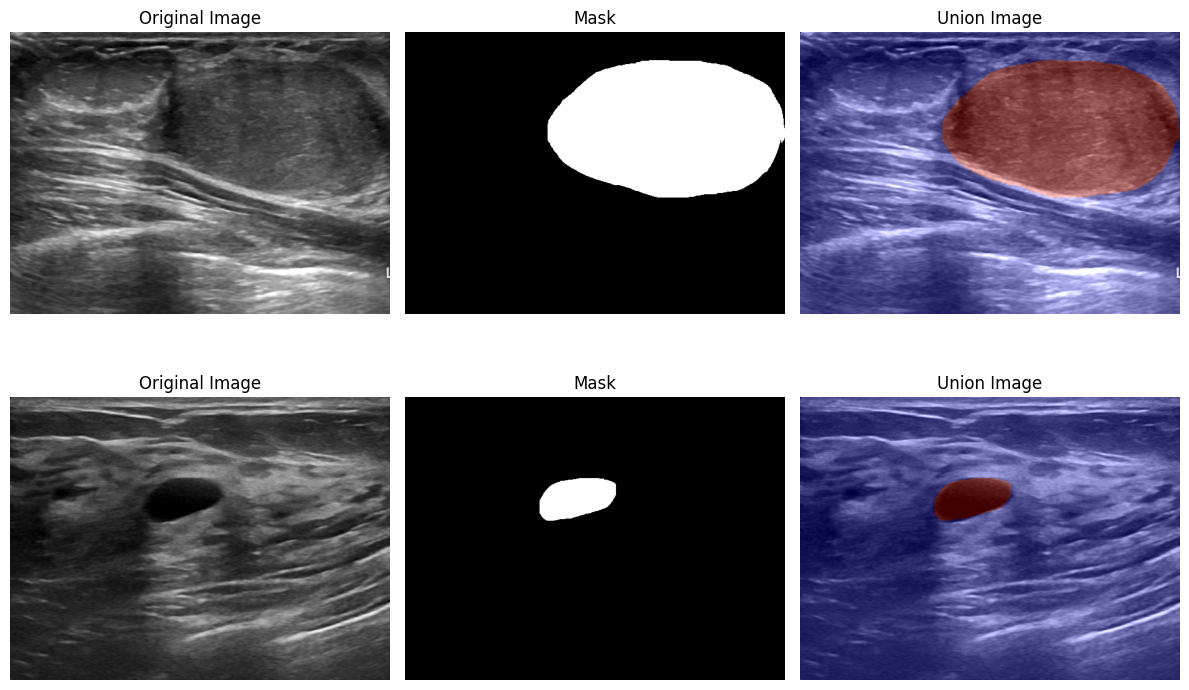

In [4]:
#from benign class
vis_images (class_name="benign")

<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>

<strong> Notes </strong>

🔘 For the class **benign**  the  image masks are located correctly



-----

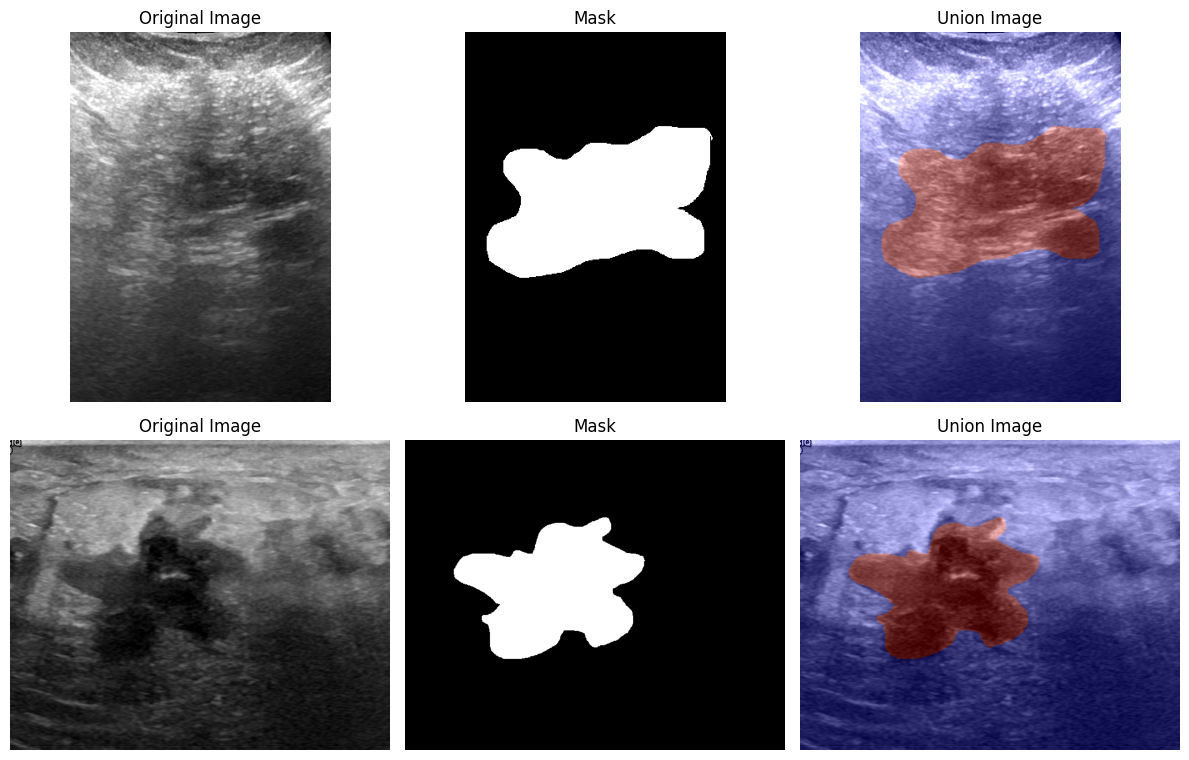

In [5]:
#from malignant class
vis_images (class_name="malignant")

<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>

<strong> Notes </strong>

🔘 For the class **malignant**  the image masks are located correctly



-------

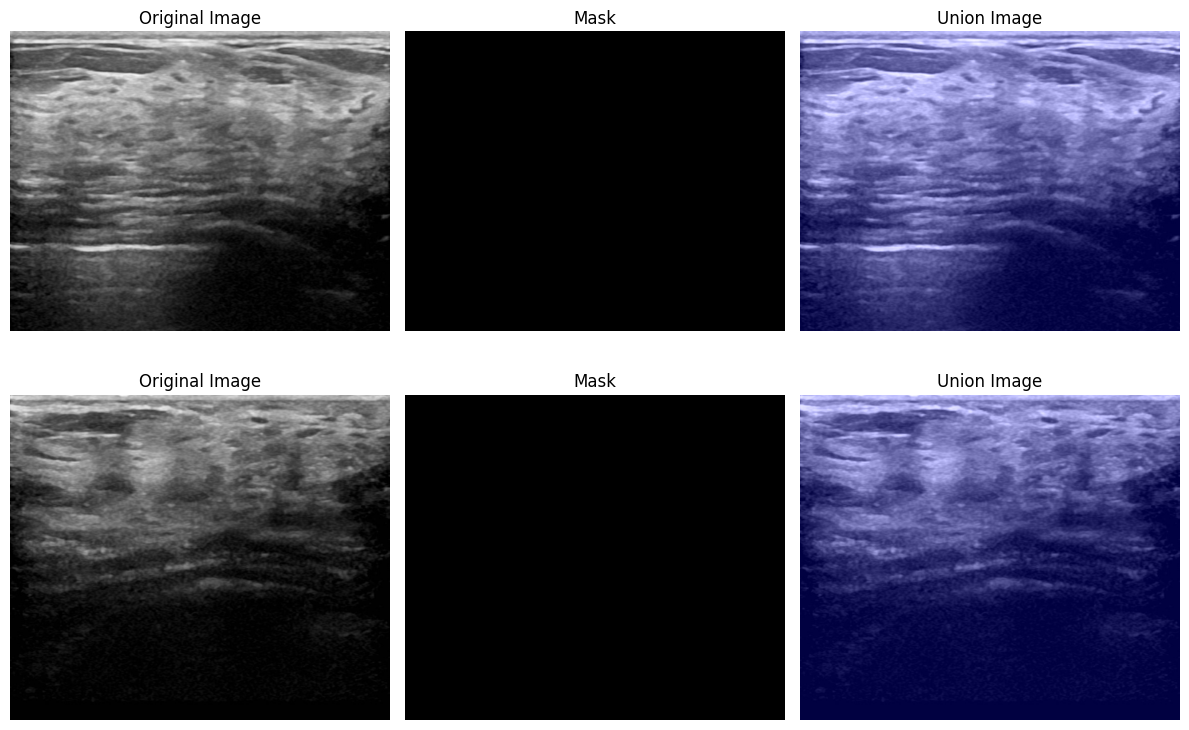

In [6]:
#from normal class
vis_images (class_name="normal")

<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>

<strong> Notes </strong>

🔘 For the class **normal** there are no image masks



---------

<a id="4"></a>
# <p style="padding:10px;background-color:#e5a3a3 ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Data preprocessing 🔧</p>




<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>
    
🔘 Since the class **normal** does not contain masks, we will process only the data contained in both  **(benign and malignant)** and non-use **normal** calss

🔘 As we noted previously, there are some images that have more than one mask. Therefore, the best solution is to combine all the masks for a single image into an image that includes all the masks (an image that includes all the masks for multi masked image).

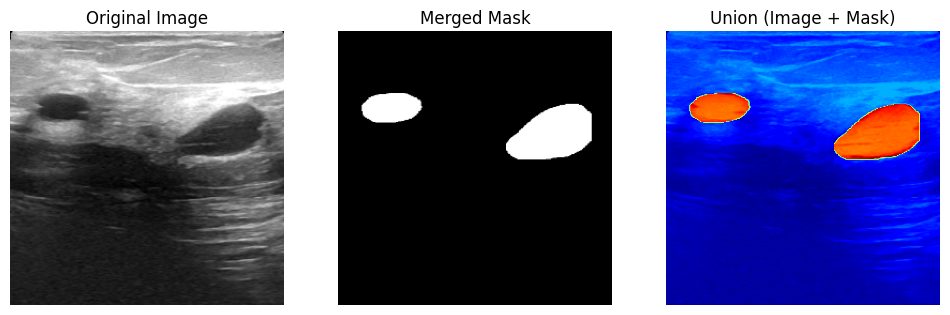

In [7]:
# this example to show what i mean
# note in the image processing this process will be automated this example to clear the idea
image_path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png" #this image from our dataset 
mask_paths = [
    "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png",# the image has two masks as shown
    "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png"
]

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (256, 256))

mask_combined = np.zeros((256, 256), dtype=np.uint8) # balck image to add the masks on it
for mask_path in mask_paths:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask_combined = np.maximum(mask_combined, mask)# to combine the masks if an image has more than one mask

# easy code to display the image >>^^
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_combined, cmap="gray")
plt.title("Merged Mask")
plt.axis("off")

union = cv2.addWeighted(image, 0.2, mask_combined, 0.5, 0)  
plt.subplot(1, 3, 3)
plt.imshow(union, cmap="jet")
plt.title("Union (Image + Mask)")
plt.axis("off")

plt.show()


<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>
    
🔘  As is clear, the masks for the image mentioned in the example have been combined into one image, and this is what is required

In [8]:
def load_data(dataset_path):
    images = [] # to store images 
    masks = [] # to store masks
    
    for category in ["benign", "malignant"]:
        category_path = os.path.join(data_path, category)
        image_files = [f for f in os.listdir(category_path) if "_mask" not in f]
        
        for img_file in image_files:
            img_path = os.path.join(category_path, img_file)
            
            mask_paths = sorted([
                os.path.join(category_path, f) 
                for f in os.listdir(category_path) 
                if f.startswith(img_file.split(".")[0] + "_mask")
            ])
            
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (256, 256)) / 255.0
            images.append(img)

            if len(mask_paths) == 1:
                mask_combined = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE)
                mask_combined = cv2.resize(mask_combined, (256, 256))
            else:
                mask_combined = np.zeros((256, 256), dtype=np.uint8)
                for mask_path in mask_paths:
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, (256, 256))
                    mask_combined = np.maximum(mask_combined, mask)

            masks.append(mask_combined / 255.0)

    return np.array(images).reshape(-1, 256, 256, 1), np.array(masks).reshape(-1, 256, 256, 1)


In [9]:
# Load dataset
dataset_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
X, Y = load_data(dataset_path) # X contain images ,Y contain masks

# Split dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
X_train.shape , Y_train.shape # Batch_size , image dims(h,w) , n_channels

((517, 256, 256, 1), (517, 256, 256, 1))

In [11]:
X_test.shape , Y_test.shape

((130, 256, 256, 1), (130, 256, 256, 1))

<a id="5"></a>
# <p style="padding:10px;background-color:#e5a3a3 ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Model Building 🤖</p>





<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>


🔘 **U-Net** is a convolutional neural network (CNN) architecture specifically designed for **semantic segmentation tasks**. Initially developed for biomedical image segmentation, U-Net has proven to be highly effective in tasks requiring pixel-level classification, where the goal is to assign a label to each pixel in an image. The architecture consists of two main parts: an encoder and a decoder, which are connected through skip connections.

🔘 **Encoder:** The encoder (also known as the contracting path) progressively **reduces the spatial dimensions of the input image using convolutional layers** followed by pooling layers. This captures high-level features and abstracts the image.

🔘 **Decoder:** The decoder (or expansive path) upsamples the feature maps to **reconstruct the spatial dimensions**. It combines the upsampled features with the corresponding feature maps from the encoder via skip connections. This helps the network retain spatial information, which is crucial for precise segmentation.

🔘 **Skip Connections:** These connections between the encoder and decoder allow the network to retain fine-grained details and context, which is essential for accurate segmentation, particularly at the boundaries of objects.



<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>

**Why Use U-Net for Breast Cancer Segmentation?**

  - High Accuracy in Semantic Segmentation: U-Net is widely regarded for its performance in tasks involving the precise segmentation of structures, which is critical in medical image analysis, such as detecting tumors in breast ultrasound images.

  - Efficient with Limited Data: U-Net's design makes it well-suited for scenarios where the available data is limited. This is important in medical imaging, where annotated data is often scarce.

  - Preserves Spatial Information: The skip connections in U-Net help preserve spatial information throughout the encoding-decoding process, making it more effective in segmenting complex structures with varying shapes and sizes, such as tumors, while maintaining high resolution at the pixel level.

  - Established Success in Medical Imaging: U-Net has been extensively tested and utilized in various medical image segmentation tasks, including breast cancer detection, proving its robustness and reliability in real-world medical applications.

<div style="text-align: center;">
        <img src="https://media.geeksforgeeks.org/wp-content/uploads/20220614121231/Group14.jpg" width="1000" height="1000">
    </div>

In [12]:
def convBlock(inputs , filters,kernel_size = (3,3)):
    x = layers.Conv2D(filters = filters , kernel_size = kernel_size , kernel_initializer='he_normal',padding = 'same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters = filters , kernel_size = kernel_size , kernel_initializer='he_normal',padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters = filters , kernel_size = kernel_size , kernel_initializer='he_normal',padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [13]:
def U_net (inputs , filters = 16 , dropoutRate=0.1):

    #Endocer
    conv1 = convBlock (inputs , filters)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    pool1 = layers.Dropout(dropoutRate)(pool1)

    conv2 = convBlock(pool1 , filters*2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    pool2 = layers.Dropout(dropoutRate)(pool2)

    conv3 = convBlock(pool2 ,filters*4)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    pool3 = layers.Dropout(dropoutRate)(pool3)

    conv4 = convBlock(pool3, filters * 8)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)
    pool4 = layers.Dropout(dropoutRate)(pool4)

    conv5 = convBlock(pool4, filters * 16)


    #Decoder 
    up6 = layers.Conv2DTranspose(filters * 8, (3, 3), strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4])
    up6 = layers.Dropout(dropoutRate)(up6)
    conv6 = convBlock(up6, filters * 8)
    
    
    up7 = layers.Conv2DTranspose(filters * 4, (3, 3), strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3])
    up7 = layers.Dropout(dropoutRate)(up7)
    conv7 = convBlock(up7, filters * 4)



    up8 = layers.Conv2DTranspose(filters * 2, (3, 3), strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2])
    up8 = layers.Dropout(dropoutRate)(up8)
    conv8 = convBlock(up8, filters * 2)


    up9 = layers.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1])
    up9 = layers.Dropout(dropoutRate)(up9)
    conv9 = convBlock(up9, filters)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    U_net_model = Model(inputs=[inputs], outputs=[outputs])

    return U_net_model

In [14]:
inputs = Input((256, 256, 1))
U_net_model = U_net(inputs, dropoutRate = 0.2)
U_net_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [15]:
U_net_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 16)   │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128, 128, 32)   │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization) 

 Total params: 3,149,489 (12.01 MB)

 Trainable params: 3,145,073 (12.00 MB)

 Non-trainable params: 4,416 (17.25 KB)

In [16]:
from tensorflow.keras.utils import plot_model
plot_model (U_net_model,to_file='unet_model.png', show_shapes=True, show_layer_names=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.956533 to fit



In [17]:
checkpoint = ModelCheckpoint('best_model.keras', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             verbose=1)


early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=15, 
                               restore_best_weights=True, 
                               verbose=1)

In [18]:
history = U_net_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=8,callbacks=[checkpoint, early_stopping])

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.8376 - loss: 0.4860
Epoch 1: val_loss improved from inf to 29.61828, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 59s 390ms/step - accuracy: 0.8382 - loss: 0.4848 - val_accuracy: 0.1539 - val_loss: 29.6183
Epoch 2/100
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9059 - loss: 0.3081
Epoch 2: val_loss improved from 29.61828 to 1.74913, saving model to best_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9061 - loss: 0.3076 - val_accuracy: 0.3084 - val_loss: 1.7491
Epoch 3/100
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9185 - loss: 0.2517
Epoch 3: val_loss did not improve from 1.74913
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9185 - loss: 0.2514 - val_accuracy: 0.3652 - val_loss: 22.2174
Epoch 4/100
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9285 - loss: 0.2179
Epoch 4: val_loss did not improve from 1.74913
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step -

<a id="6"></a>
# <p style="padding:10px;background-color:#e5a3a3 ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Model Evaluation 📈</p>

In [19]:
U_net_model.evaluate(X_test, Y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9604 - loss: 0.1384


[0.1540929526090622, 0.9567348957061768]

In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(len(history.history['loss']))),
                         y=history.history['loss'],
                         mode='lines',
                         name='Train Loss'))

fig.add_trace(go.Scatter(x=list(range(len(history.history['val_loss']))),
                         y=history.history['val_loss'],
                         mode='lines',
                         name='Validation Loss'))

fig.add_trace(go.Scatter(x=list(range(len(history.history['accuracy']))),
                         y=history.history['accuracy'],
                         mode='lines',
                         name='Train Accuracy'))

fig.add_trace(go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                         y=history.history['val_accuracy'],
                         mode='lines',
                         name='Validation Accuracy'))

fig.update_layout(
    title="Training and Validation Metrics",
    xaxis_title="Epoch",
    yaxis_title="Value",
    legend_title="Metrics",
    template="plotly_dark",
    height=600,
    paper_bgcolor='#e5a3a3',
    plot_bgcolor='#e5a3a3',
)

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>

# **Dice Coefficient & Jaccard Index (IoU)   

## **1️⃣ Dice Coefficient**  
The **Dice Coefficient (Dice Score)** measures how similar the predicted segmentation mask is to the ground truth mask.  

- It considers both **false positives** and **false negatives**, making it useful for evaluating segmentation models.  
- It is widely used in **medical image segmentation** and cases where the foreground object is much smaller than the background.  

### 🔹 **Why is it important?**  
- It helps evaluate how well the model is capturing the correct object boundaries.  
- It works well in cases where there is a class imbalance (small objects in large backgrounds).  

---

## **2️⃣ Jaccard Index (IoU - Intersection over Union)**  
The **Jaccard Index (IoU)** is another key metric for evaluating segmentation models.  

- It measures how much overlap exists between the predicted and actual masks.  
- Unlike Dice, IoU gives more **strict penalties** for incorrect predictions.  

### 🔹 **Why is it important?**  
- It is commonly used in **benchmark segmentation challenges** like the COCO dataset.  
- It provides a **stricter evaluation** by penalizing both false positives and false negatives.  

---

## **🔍 Key Differences**  
| Metric  | Sensitivity to Imbalanced Data  | Common Use Cases |
|---------|--------------------------------|----------------|
| **Dice Coefficient**  | More sensitive to small objects  | Medical image segmentation, small object detection |
| **IoU (Jaccard Index)**  | Less sensitive, penalizes more | General segmentation benchmarks, COCO dataset |

---

## **✅ Which One to Use?**  
- If the dataset contains **small objects** and is highly **imbalanced** → **Dice is preferred**  
- If a **stricter evaluation** is required → **IoU is better**  
- In most cases, **both are used together** for a complete evaluation  

📌 **In this notebook, we use both Dice Coefficient & IoU to ensure a robust evaluation of our segmentation model!** 🚀


In [21]:
def dice_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def evaluate_model(model, X_test, Y_test, threshold=0.5):
    preds = model.predict(X_test)  
    preds = (preds > threshold).astype(np.uint8) 
    
    dice_scores = []
    jaccard_scores = []
    
    for i in range(len(Y_test)):
        dice = dice_score(Y_test[i], preds[i])
        jaccard = jaccard_index(Y_test[i], preds[i])
        
        dice_scores.append(dice)
        jaccard_scores.append(jaccard)

    print(f"Dice Coefficient: {np.mean(dice_scores):.4f}")
    print(f"Jaccard Index (IoU): {np.mean(jaccard_scores):.4f}")

evaluate_model(U_net_model, X_test, Y_test)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step
Dice Coefficient: 0.7303
Jaccard Index (IoU): 0.6439


----

In [22]:
def test_model(model, X_test, Y_test, num_samples=4):
    preds = model.predict(X_test[:num_samples])  

    fig, axes = plt.subplots(num_samples, 4, figsize=(12, 9))  

    for i in range(num_samples):
        original_img = X_test[i] 
        true_mask = Y_test[i]  
        predicted_mask = preds[i] 

        pred_mask_255 = (predicted_mask * 255).astype(np.uint8)
        jet_mask = cv2.applyColorMap(pred_mask_255, cv2.COLORMAP_JET)

        union = cv2.addWeighted(cv2.cvtColor((original_img * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR), 
                                0.7, jet_mask, 0.3, 0)

        axes[i, 0].imshow(original_img, cmap='gray')
        axes[i, 0].set_title("Original Image")
        axes[i, 1].imshow(true_mask, cmap='gray')
        axes[i, 1].set_title("True Mask")
        axes[i, 2].imshow(predicted_mask, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 3].imshow(union)
        axes[i, 3].set_title("Original + predicted Mask")

        for j in range(4):
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


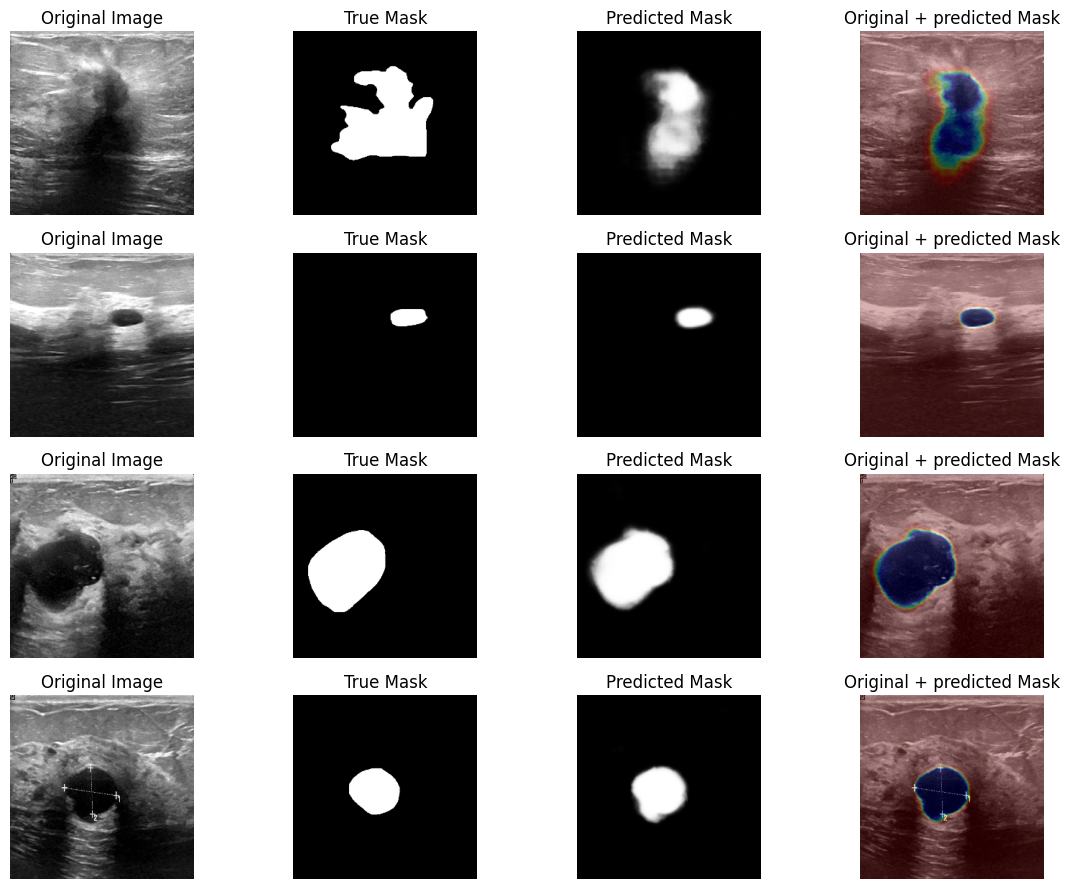

In [23]:
test_model(U_net_model,X_test,Y_test)


<div style = 'border : 3px solid #e5a3a3; background-color:#f7e9e9;padding:10px; border-radius: 25px;'>

# Thank you for watching for the end ❤️